# Car Price Prediction - Complete ML Pipeline
## Implementing 5 Different Models

This notebook contains:
- Data preprocessing and feature engineering
- Multiple encoding strategies
- Implementation of 5 distinct machine learning models:
  1. **Linear Regression** (Regression)
  2. **Logistic Regression** (Classification - Price Category)
  3. **K-Nearest Neighbor (KNN)** (Regression)
  4. **Decision Tree** (Regression)
  5. **K-Means Clustering** (Unsupervised Learning)
- Comprehensive evaluation and comparison


## 1. Import Libraries and Setup

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore')

# Preprocessing and modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error,
    accuracy_score,
    classification_report,
    confusion_matrix,
    silhouette_score
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# XGBoost (install if needed: pip install xgboost)
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    print("XGBoost not available. Install with: pip install xgboost")
    XGBOOST_AVAILABLE = False

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## 2. Configuration

In [2]:
# Configuration parameters
class Config:
    # Target and ID
    TARGET = 'Price'
    ID_COL = 'ID'
    
    # Columns to drop
    DROP_COLS = ['ID', 'Doors', 'Prod. year']
    
    # Numerical features
    NUMERICAL_COLS = ['Levy', 'Engine volume', 'Mileage', 'Age']
    
    # Categorical encoding strategies
    OHE_COLS = ['Leather interior', 'Gear box type', 'Drive wheels', 'Wheel']
    TARGET_ENC_COLS = ['Fuel type', 'Model', 'Airbags', 'Cylinders', 'Manufacturer']
    LABEL_ENC_COLS = ['Category', 'Color']
    
    # Training parameters
    TEST_SIZE = 0.2
    RANDOM_STATE = 42
    
    # Outlier removal
    OUTLIER_REMOVAL = True
    IQR_MULTIPLIER = 1.5
    OUTLIER_COLS = ['Price', 'Levy', 'Engine volume', 'Mileage']

print("✓ Configuration loaded")

✓ Configuration loaded


## 3. Data Preprocessing Functions

In [3]:
# Data cleaning functions
def clean_levy(value):
    """Convert levy: '-' to 0, otherwise to float"""
    if str(value) == '-':
        return 0.0
    try:
        return float(value)
    except:
        return 0.0

def clean_engine_volume(value):
    """Remove 'Turbo' and convert to float"""
    try:
        return float(str(value).split()[0])
    except:
        return 0.0

def clean_mileage(value):
    """Remove 'km' and convert to float"""
    try:
        return float(str(value).replace('km', '').replace(',', '').strip())
    except:
        return 0.0

def calculate_age(df, year_col='Prod. year'):
    """Calculate vehicle age from production year"""
    df = df.copy()
    current_year = datetime.datetime.now().year
    df[year_col] = pd.to_numeric(df[year_col], errors='coerce')
    df['Age'] = current_year - df[year_col]
    df['Age'] = df['Age'].clip(lower=0, upper=100)
    return df

def remove_outliers_iqr(df, columns, multiplier=1.5):
    """Remove outliers using IQR method"""
    df_clean = df.copy()
    initial_count = len(df_clean)
    
    for col in columns:
        if col not in df_clean.columns:
            continue
        
        q1 = df_clean[col].quantile(0.25)
        q3 = df_clean[col].quantile(0.75)
        iqr = q3 - q1
        
        lower_bound = q1 - multiplier * iqr
        upper_bound = q3 + multiplier * iqr
        
        df_clean = df_clean[
            (df_clean[col] >= lower_bound) & 
            (df_clean[col] <= upper_bound)
        ]
    
    print(f"Removed {initial_count - len(df_clean)} outliers ({(initial_count - len(df_clean)) / initial_count * 100:.2f}%)")
    return df_clean

def preprocess_data(df, is_training=True):
    """Main preprocessing pipeline"""
    print("Starting preprocessing...")
    df = df.copy()
    
    # Clean numerical columns
    if 'Levy' in df.columns:
        df['Levy'] = df['Levy'].apply(clean_levy)
    if 'Engine volume' in df.columns:
        df['Engine volume'] = df['Engine volume'].apply(clean_engine_volume)
    if 'Mileage' in df.columns:
        df['Mileage'] = df['Mileage'].apply(clean_mileage)
    
    # Feature engineering
    if 'Prod. year' in df.columns:
        df = calculate_age(df)
    
    # Remove duplicates
    df = df.drop_duplicates()
    
    # Remove outliers (training only)
    if is_training and Config.OUTLIER_REMOVAL:
        df = remove_outliers_iqr(df, Config.OUTLIER_COLS, Config.IQR_MULTIPLIER)
    
    print(f"Preprocessing complete. Shape: {df.shape}")
    return df

print("✓ Preprocessing functions defined")

✓ Preprocessing functions defined


## 4. Encoding Classes

In [4]:
class TargetEncoder:
    """Target encoding for high-cardinality features"""

    def __init__(self):
        self.mappings: dict = {}
        self.global_mean: float = 0.0

    def fit(self, X: pd.DataFrame, y: pd.Series, columns: list) -> 'TargetEncoder':
        self.global_mean = float(y.mean())
        df_combined = X.copy()
        df_combined['__target__'] = y.values

        for col in columns:
            if col in X.columns:
                mapping = df_combined.groupby(col)['__target__'].mean()
                self.mappings[col] = mapping.to_dict()
        return self

    def transform(self, X: pd.DataFrame, columns: list) -> pd.DataFrame:
        X_encoded = X.copy()
        for col in columns:
            if col in X_encoded.columns and col in self.mappings:
                X_encoded[col] = X_encoded[col].map(
                    self.mappings[col]).fillna(self.global_mean)
        return X_encoded

    def fit_transform(self, X: pd.DataFrame, y: pd.Series, columns: list) -> pd.DataFrame:
        self.fit(X, y, columns)
        return self.transform(X, columns)


class SafeLabelEncoder:
    """Label encoder with safe handling of unseen categories"""

    def __init__(self):
        self.mappings: dict = {}

    def fit(self, X: pd.DataFrame, columns: list) -> 'SafeLabelEncoder':
        for col in columns:
            if col in X.columns:
                le = LabelEncoder()
                le.fit(X[col].astype(str))
                self.mappings[col] = dict(
                    zip(le.classes_, le.transform(le.classes_).tolist()))
        return self

    def transform(self, X: pd.DataFrame, columns: list) -> pd.DataFrame:
        X_encoded = X.copy()
        for col in columns:
            if col in X_encoded.columns and col in self.mappings:
                X_encoded[col] = X_encoded[col].astype(str).map(
                    self.mappings[col]
                ).fillna(-1).astype(int)
        return X_encoded

    def fit_transform(self, X: pd.DataFrame, columns: list) -> pd.DataFrame:
        self.fit(X, columns)
        return self.transform(X, columns)


class OneHotEncoderWrapper:
    """One-hot encoder with pandas DataFrame support"""

    def __init__(self):
        self.encoder: OneHotEncoder = OneHotEncoder(
            handle_unknown='ignore', sparse_output=False)
        self.feature_names: np.ndarray | None = None
        self.columns: list = []

    def fit(self, X: pd.DataFrame, columns: list) -> 'OneHotEncoderWrapper':
        self.columns = [col for col in columns if col in X.columns]
        if self.columns:
            self.encoder.fit(X[self.columns])
            self.feature_names = self.encoder.get_feature_names_out(
                self.columns)
        return self

    def transform(self, X: pd.DataFrame, columns: list) -> pd.DataFrame:
        X_transformed = X.copy()
        if self.columns:
            encoded_data = self.encoder.transform(X_transformed[self.columns])
            encoded_df = pd.DataFrame(
                encoded_data,
                columns=self.feature_names,
                index=X_transformed.index
            )
            X_transformed = pd.concat([X_transformed, encoded_df], axis=1)
            X_transformed = X_transformed.drop(columns=self.columns)
        return X_transformed

    def fit_transform(self, X: pd.DataFrame, columns: list) -> pd.DataFrame:
        self.fit(X, columns)
        return self.transform(X, columns)


print("✓ Encoding classes defined")

✓ Encoding classes defined


## 5. Load and Explore Data

In [5]:
# Load data - UPDATE THIS PATH TO YOUR DATA FILE
DATA_PATH = 'car_price_prediction.csv'  # Change this to your file path

try:
    df_raw = pd.read_csv(DATA_PATH)
    print(f"✓ Data loaded successfully: {df_raw.shape}")
    print(f"\nColumns: {list(df_raw.columns)}")
except FileNotFoundError:
    print(f"❌ File not found: {DATA_PATH}")
    print("Please update DATA_PATH variable with the correct path to your CSV file")

✓ Data loaded successfully: (19237, 18)

Columns: ['ID', 'Price', 'Levy', 'Manufacturer', 'Model', 'Prod. year', 'Category', 'Leather interior', 'Fuel type', 'Engine volume', 'Mileage', 'Cylinders', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color', 'Airbags']


In [6]:
# Display basic information
print("Dataset Info:")
print(df_raw.info())
print("\nFirst few rows:")
df_raw.head()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 no

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


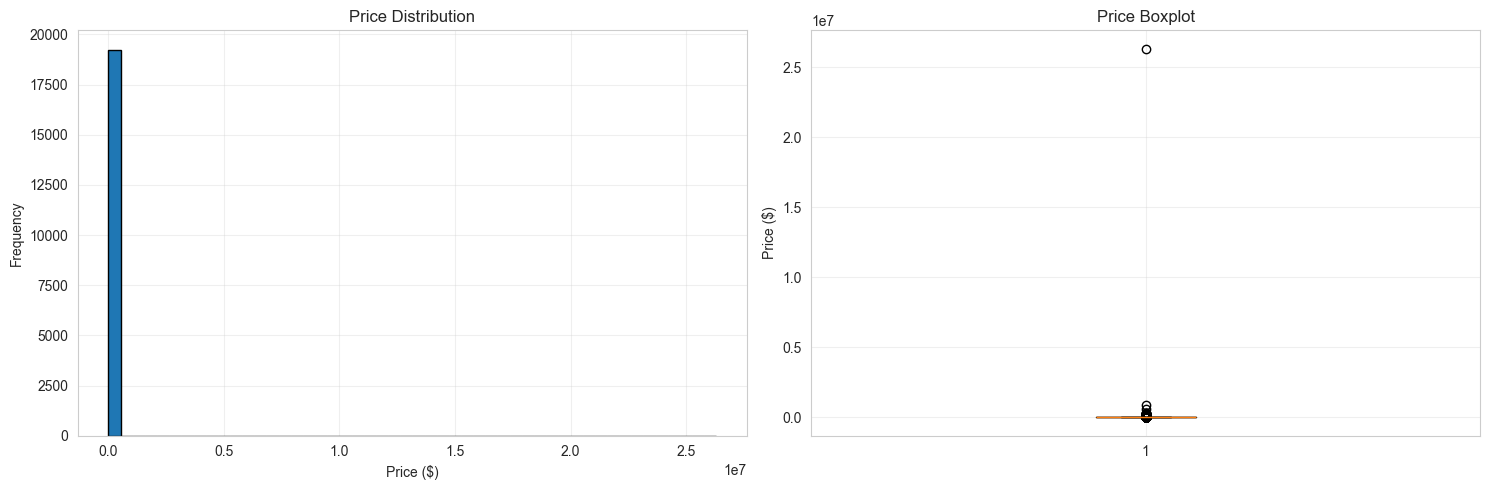

Price Statistics:
count    1.923700e+04
mean     1.855593e+04
std      1.905813e+05
min      1.000000e+00
25%      5.331000e+03
50%      1.317200e+04
75%      2.207500e+04
max      2.630750e+07
Name: Price, dtype: float64


In [7]:
# Target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(df_raw[Config.TARGET], bins=50, edgecolor='black')
axes[0].set_xlabel('Price ($)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Price Distribution')
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(df_raw[Config.TARGET])
axes[1].set_ylabel('Price ($)')
axes[1].set_title('Price Boxplot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Price Statistics:")
print(df_raw[Config.TARGET].describe())

## 6. Data Preprocessing

In [8]:
# Preprocess data
df = preprocess_data(df_raw, is_training=True)

# Separate features and target
X = df.drop(Config.TARGET, axis=1)
y = df[Config.TARGET]

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target statistics: mean=${y.mean():,.2f}, std=${y.std():,.2f}")

Starting preprocessing...
Removed 2887 outliers (15.26%)
Preprocessing complete. Shape: (16037, 19)

Feature matrix shape: (16037, 18)
Target shape: (16037,)
Target statistics: mean=$14,295.18, std=$11,286.94


In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=Config.TEST_SIZE,
    random_state=Config.RANDOM_STATE
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 12829 samples
Test set: 3208 samples


## 7. Feature Encoding and Scaling

In [10]:
# Initialize encoders
target_encoder = TargetEncoder()
label_encoder = SafeLabelEncoder()
ohe_encoder = OneHotEncoderWrapper()
scaler = StandardScaler()

# Fit and transform training data
print("Encoding training data...")
X_train_enc = target_encoder.fit_transform(X_train, y_train, Config.TARGET_ENC_COLS)
X_train_enc = label_encoder.fit_transform(X_train_enc, Config.LABEL_ENC_COLS)
X_train_enc = ohe_encoder.fit_transform(X_train_enc, Config.OHE_COLS)

# Drop unused columns
cols_to_drop = [c for c in Config.DROP_COLS if c in X_train_enc.columns]
X_train_enc = X_train_enc.drop(columns=cols_to_drop)

# Scale numerical features
cols_to_scale = [c for c in Config.NUMERICAL_COLS + Config.TARGET_ENC_COLS if c in X_train_enc.columns]
X_train_enc[cols_to_scale] = scaler.fit_transform(X_train_enc[cols_to_scale])

print(f"Training features after encoding: {X_train_enc.shape}")

# Transform test data
print("\nEncoding test data...")
X_test_enc = target_encoder.transform(X_test, Config.TARGET_ENC_COLS)
X_test_enc = label_encoder.transform(X_test_enc, Config.LABEL_ENC_COLS)
X_test_enc = ohe_encoder.transform(X_test_enc, Config.OHE_COLS)
X_test_enc = X_test_enc.drop(columns=[c for c in cols_to_drop if c in X_test_enc.columns])
X_test_enc[cols_to_scale] = scaler.transform(X_test_enc[cols_to_scale])

# Align columns
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

print(f"Test features after encoding: {X_test_enc.shape}")
print(f"\n✓ Feature engineering complete")

Encoding training data...
Training features after encoding: (12829, 22)

Encoding test data...
Test features after encoding: (3208, 22)

✓ Feature engineering complete


## 8. Model Training and Evaluation
### Train 5 Different Models


In [11]:
def calculate_metrics(y_true, y_pred, model_name):
    """Calculate and return regression metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    try:
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    except:
        mape = None
    
    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE (%)': mape
    }

# Dictionary to store models and results
models = {}
results = []
model_summary = [] # Unified list for all model types

print("Training models...\n")

Training models...



### Model 1: Linear Regression

In [12]:
print("=" * 70)
print("MODEL 1: Linear Regression")
print("=" * 70)

lr_model = LinearRegression(
    n_jobs=-1
)

lr_model.fit(X_train_enc, y_train)
lr_train_pred = lr_model.predict(X_train_enc)
lr_test_pred = lr_model.predict(X_test_enc)

models['Linear Regression'] = lr_model
results.append(calculate_metrics(y_test, lr_test_pred, 'Linear Regression'))
model_summary.append({'Model': 'Linear Regression', 'Task': 'Regression', 'Metric': 'RMSE (Lower is better)', 'Score': results[-1]['RMSE']})

print("Training Metrics:")
train_metrics = calculate_metrics(y_train, lr_train_pred, 'Linear Regression')
print(f"  R²: {train_metrics['R²']:.4f}")
print(f"  RMSE: ${train_metrics['RMSE']:,.2f}")
print(f"  MAE: ${train_metrics['MAE']:,.2f}")

print("\nTest Metrics:")
print(f"  R²: {results[-1]['R²']:.4f}")
print(f"  RMSE: ${results[-1]['RMSE']:,.2f}")
print(f"  MAE: ${results[-1]['MAE']:,.2f}")
if results[-1]['MAPE (%)']:
    print(f"  MAPE: {results[-1]['MAPE (%)']:.2f}%")

print("\n✓ Linear Regression trained successfully")

MODEL 1: Linear Regression
Training Metrics:
  R²: 0.5209
  RMSE: $7,798.14
  MAE: $5,911.69

Test Metrics:
  R²: 0.4590
  RMSE: $8,358.51
  MAE: $6,368.91
  MAPE: 1482.09%

✓ Linear Regression trained successfully


### Model 2: Logistic Regression (Classification)
Since Logistic Regression is a classification algorithm, we will transform the regression problem into a classification task.
We will create two classes based on the median price:
- **0 (Low Price)**: Price <= Median
- **1 (High Price)**: Price > Median


In [13]:
print("\n" + "=" * 70)
print("MODEL 2: Logistic Regression (Classification)")
print("=" * 70)

# Create classification target
median_price = y_train.median()
y_train_class = (y_train > median_price).astype(int)
y_test_class = (y_test > median_price).astype(int)

print(f"Price Classification Threshold (Median): ${median_price:,.2f}")
print(f"Class distribution (Train): {np.bincount(y_train_class)}")

# Train Logistic Regression
log_reg = LogisticRegression(
    max_iter=1000,
    random_state=Config.RANDOM_STATE,
    n_jobs=-1
)

log_reg.fit(X_train_enc, y_train_class)
log_reg_pred = log_reg.predict(X_test_enc)

# Evaluate
accuracy = accuracy_score(y_test_class, log_reg_pred)
model_summary.append({'Model': 'Logistic Regression', 'Task': 'Classification', 'Metric': 'Accuracy (Higher is better)', 'Score': accuracy})

print(f"\nLogistic Regression Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_class, log_reg_pred, target_names=['Low Price', 'High Price']))

print("\n✓ Logistic Regression trained successfully")


MODEL 2: Logistic Regression (Classification)
Price Classification Threshold (Median): $12,560.00
Class distribution (Train): [6415 6414]



Logistic Regression Accuracy: 0.8042

Classification Report:
              precision    recall  f1-score   support

   Low Price       0.80      0.81      0.81      1631
  High Price       0.81      0.79      0.80      1577

    accuracy                           0.80      3208
   macro avg       0.80      0.80      0.80      3208
weighted avg       0.80      0.80      0.80      3208


✓ Logistic Regression trained successfully


### Model 3: K-Nearest Neighbor (KNN)

In [14]:
print("\n" + "=" * 70)
print("MODEL 3: K-Nearest Neighbors (KNN) Regressor")
print("=" * 70)

knn_model = KNeighborsRegressor(
    n_neighbors=5,
    weights='distance',
    algorithm='auto',
    n_jobs=-1
)

knn_model.fit(X_train_enc, y_train)
knn_train_pred = knn_model.predict(X_train_enc)
knn_test_pred = knn_model.predict(X_test_enc)

models['KNN'] = knn_model
results.append(calculate_metrics(y_test, knn_test_pred, 'KNN'))
model_summary.append({'Model': 'KNN', 'Task': 'Regression', 'Metric': 'RMSE (Lower is better)', 'Score': results[-1]['RMSE']})

print("Training Metrics:")
train_metrics = calculate_metrics(y_train, knn_train_pred, 'KNN')
print(f"  R²: {train_metrics['R²']:.4f}")
print(f"  RMSE: ${train_metrics['RMSE']:,.2f}")
print(f"  MAE: ${train_metrics['MAE']:,.2f}")

print("\nTest Metrics:")
print(f"  R²: {results[-1]['R²']:.4f}")
print(f"  RMSE: ${results[-1]['RMSE']:,.2f}")
print(f"  MAE: ${results[-1]['MAE']:,.2f}")
if results[-1]['MAPE (%)']:
    print(f"  MAPE: {results[-1]['MAPE (%)']:.2f}%")

print("\n✓ KNN trained successfully")


MODEL 3: K-Nearest Neighbors (KNN) Regressor
Training Metrics:
  R²: 0.9950
  RMSE: $797.66
  MAE: $83.21

Test Metrics:
  R²: 0.6906
  RMSE: $6,321.38
  MAE: $3,789.84
  MAPE: 977.96%

✓ KNN trained successfully


### Model 4: Decision Tree

In [15]:
print("\n" + "=" * 70)
print("MODEL 4: Decision Tree Regressor")
print("=" * 70)

dt_model = DecisionTreeRegressor(
    max_depth=10,
    min_samples_split=5,
    random_state=Config.RANDOM_STATE
)

dt_model.fit(X_train_enc, y_train)
dt_train_pred = dt_model.predict(X_train_enc)
dt_test_pred = dt_model.predict(X_test_enc)

models['Decision Tree'] = dt_model
results.append(calculate_metrics(y_test, dt_test_pred, 'Decision Tree'))
model_summary.append({'Model': 'Decision Tree', 'Task': 'Regression', 'Metric': 'RMSE (Lower is better)', 'Score': results[-1]['RMSE']})

print("Training Metrics:")
train_metrics = calculate_metrics(y_train, dt_train_pred, 'Decision Tree')
print(f"  R²: {train_metrics['R²']:.4f}")
print(f"  RMSE: ${train_metrics['RMSE']:,.2f}")
print(f"  MAE: ${train_metrics['MAE']:,.2f}")

print("\nTest Metrics:")
print(f"  R²: {results[-1]['R²']:.4f}")
print(f"  RMSE: ${results[-1]['RMSE']:,.2f}")
print(f"  MAE: ${results[-1]['MAE']:,.2f}")
if results[-1]['MAPE (%)']:
    print(f"  MAPE: {results[-1]['MAPE (%)']:.2f}%")

print("\n✓ Decision Tree trained successfully")


MODEL 4: Decision Tree Regressor
Training Metrics:
  R²: 0.7775
  RMSE: $5,314.99
  MAE: $3,601.80

Test Metrics:
  R²: 0.6375
  RMSE: $6,842.46
  MAE: $4,615.19
  MAPE: 1407.47%

✓ Decision Tree trained successfully


In [16]:
# Model 5: K-Means Clustering

In [17]:
print("\n" + "=" * 70)
print("MODEL 5: K-Means Clustering (Unsupervised)")
print("=" * 70)

# We will cluster the data based on the features to find natural groupings
# Using a subset for silhouette score calculation if dataset is large
sample_size = min(10000, len(X_train_enc))
X_sample = X_train_enc.sample(n=sample_size, random_state=Config.RANDOM_STATE)

n_clusters = 5
kmeans = KMeans(
    n_clusters=n_clusters,
    random_state=Config.RANDOM_STATE,
    n_init=10
)

print(f"Fitting K-Means with {n_clusters} clusters...")
kmeans.fit(X_train_enc)
cluster_labels = kmeans.labels_

# Calculate Silhouette Score (on sample)
sil_score = silhouette_score(X_sample, kmeans.predict(X_sample))
model_summary.append({'Model': 'K-Means', 'Task': 'Clustering', 'Metric': 'Silhouette Score (Higher is better)', 'Score': sil_score})

print(f"Silhouette Score (on sample of {sample_size}): {sil_score:.4f}")

# Analyze clusters
df_clusters = X_train.copy()
df_clusters['Cluster'] = cluster_labels
df_clusters['Price'] = y_train

print("\nAverage Price per Cluster:")
print(df_clusters.groupby('Cluster')['Price'].mean().sort_values())

print("\n✓ K-Means Clustering completed")


MODEL 5: K-Means Clustering (Unsupervised)
Fitting K-Means with 5 clusters...
Silhouette Score (on sample of 10000): 0.3226

Average Price per Cluster:
Cluster
1    12858.084142
2    13933.451114
3    14741.741770
4    15054.751098
0    15200.039911
Name: Price, dtype: float64

✓ K-Means Clustering completed


## 9. Model Comparison
### Comparing Performance on Test Data

In [18]:
print("FULL MODEL COMPARISON:")
summary_df = pd.DataFrame(model_summary)
if not summary_df.empty:
    # Reorder columns
    summary_df = summary_df[['Model', 'Task', 'Metric', 'Score']]
    print(summary_df)
else:
    print("No model results to display.")

print("\n" + "="*50)
print("REGRESSION MODEL DETAILED COMPARISON:")
results_df = pd.DataFrame(results)
if not results_df.empty:
    results_df = results_df.sort_values(by='RMSE', ascending=True).reset_index(drop=True)
    print(results_df)
else:
    print("No regression results to display.")

FULL MODEL COMPARISON:
                 Model            Task                               Metric  \
0    Linear Regression      Regression               RMSE (Lower is better)   
1  Logistic Regression  Classification          Accuracy (Higher is better)   
2                  KNN      Regression               RMSE (Lower is better)   
3        Decision Tree      Regression               RMSE (Lower is better)   
4              K-Means      Clustering  Silhouette Score (Higher is better)   

         Score  
0  8358.510565  
1     0.804239  
2  6321.376164  
3  6842.464330  
4     0.322554  

REGRESSION MODEL DETAILED COMPARISON:
               Model         RMSE          MAE        R²     MAPE (%)
0                KNN  6321.376164  3789.841578  0.690575   977.961582
1      Decision Tree  6842.464330  4615.189023  0.637459  1407.473411
2  Linear Regression  8358.510565  6368.913447  0.459010  1482.088335


## 10. Visualization and Analysis

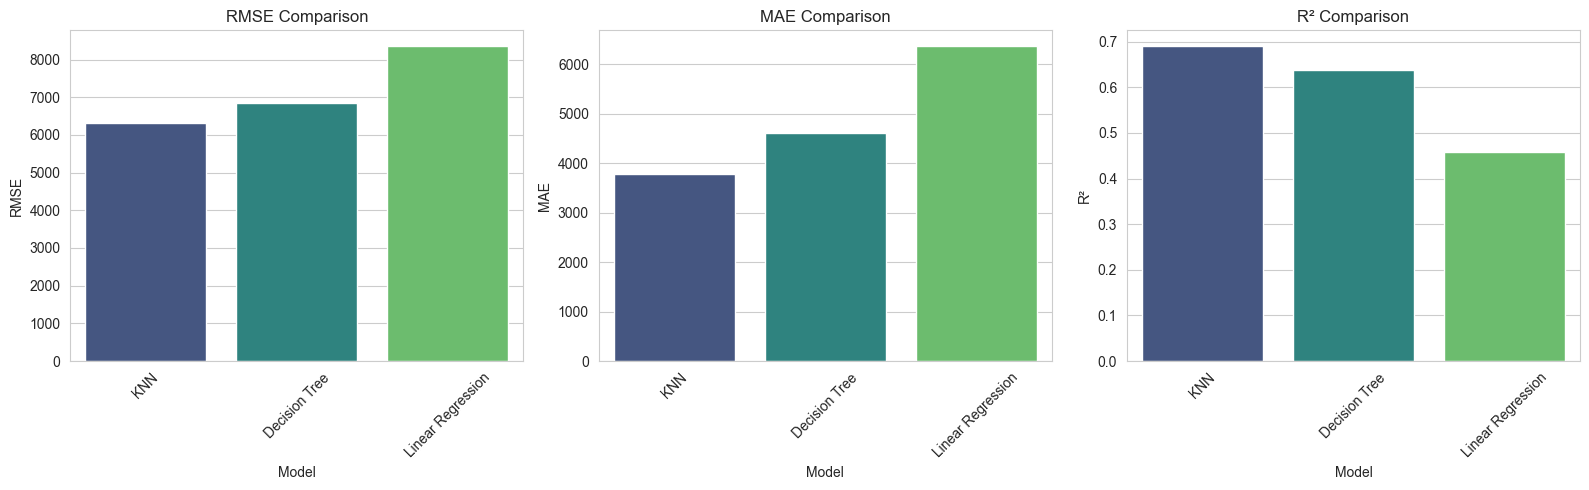

The best regression model based on RMSE is: KNN


In [19]:
# Plotting metric comparisons for Regression Models
if not results_df.empty:
    plt.figure(figsize=(16, 5))
    metric_cols = ['RMSE', 'MAE', 'R²']

    for i, metric in enumerate(metric_cols):
        plt.subplot(1, 3, i + 1)
        order = results_df.sort_values(by=metric, ascending=False)['Model'] if metric == 'R²' else results_df.sort_values(by=metric, ascending=True)['Model']
        sns.barplot(x='Model', y=metric, data=results_df, palette='viridis', order=order)
        plt.title(f'{metric} Comparison')
        plt.xticks(rotation=45)
        
    plt.tight_layout()
    plt.show()

    # Determine the best model for residual plot
    best_model_name = results_df.iloc[0]['Model']
    best_model = models[best_model_name]
    best_preds = best_model.predict(X_test_enc)

    print(f"The best regression model based on RMSE is: {best_model_name}")
else:
    print("No regression models to visualize.")

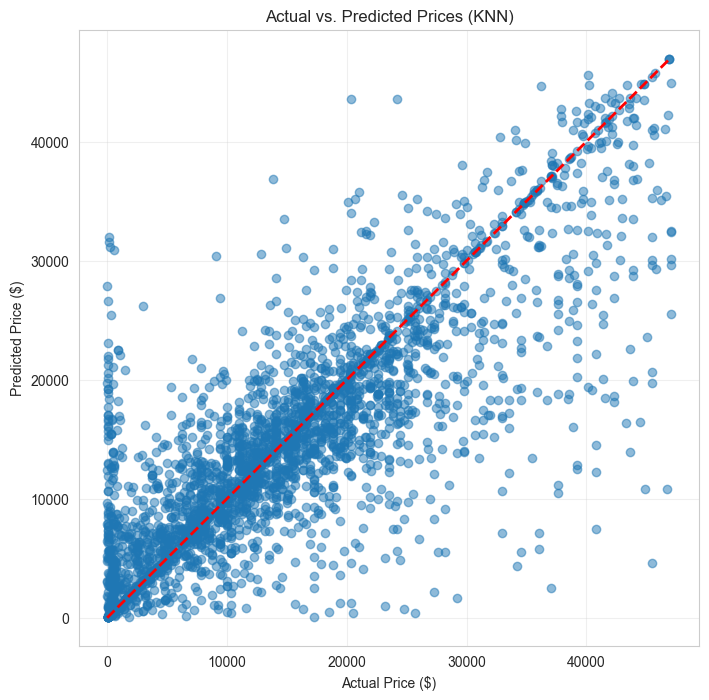

In [20]:
# Actual vs. Predicted Plot for the Best Model
plt.figure(figsize=(8, 8))
plt.scatter(y_test, best_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Diagonal line
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title(f'Actual vs. Predicted Prices ({best_model_name})')
plt.grid(True, alpha=0.3)
plt.show()